In [1]:
import os
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches as mpatches

import sys
sys.path.append('../../')
from rllte.evaluation.visualization import _annotate_and_decorate_axis, plot_interval_estimates
from rllte.evaluation import Performance
from utils import smooth

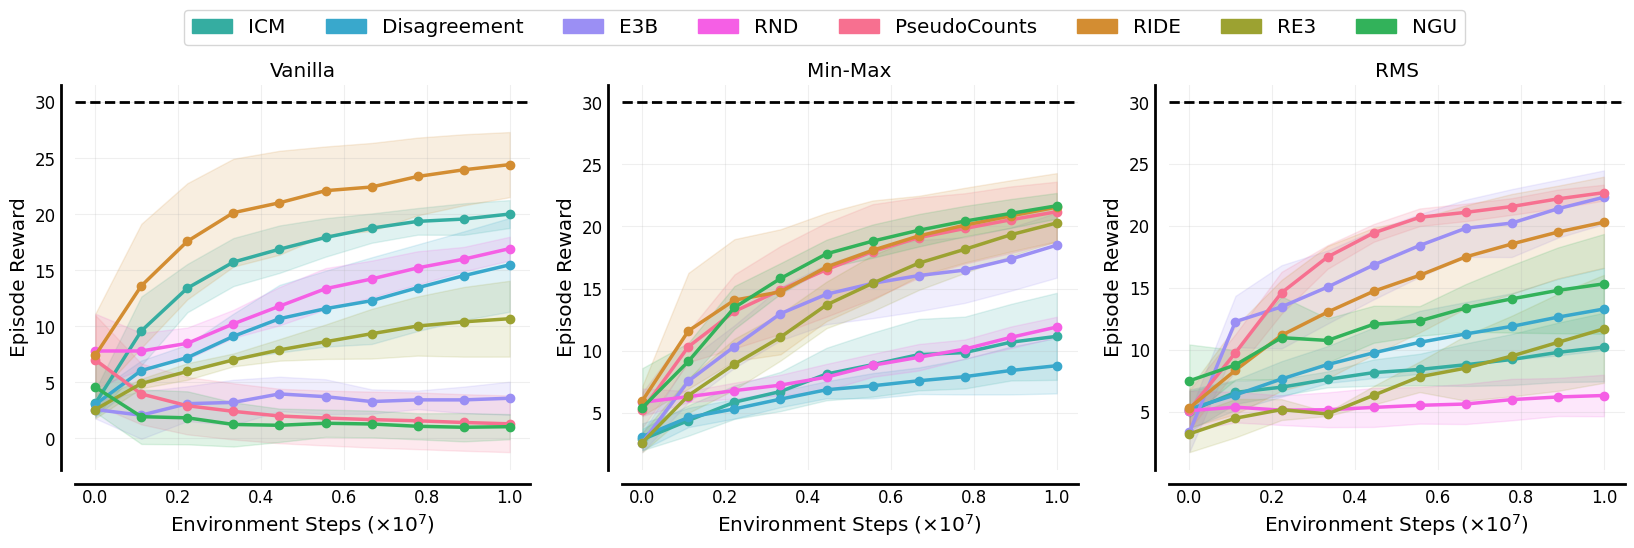

In [3]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
titles = ['Vanilla', 'Min-Max', 'RMS']
# colors = sns.color_palette("husl", len(algos))
colors = sns.husl_palette(len(algos), h=.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(algos)]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for subplot_idx, candidate in enumerate(['none', 'minmax', 'rms']):
    root = f"./data/q2/{candidate}/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    ax = axes[subplot_idx]

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                data = smooth(data, 0.95)
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])

    x = np.linspace(0, 1, num_points)
    ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
    for algo, color in zip(algos, colors):
        mean, std = np.mean(all_data[algo], axis=0), np.std(all_data[algo], axis=0)
        ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=color, label=algo)
        ax.fill_between(x, mean+std, mean-std, alpha=0.15, color=color)

    ax.set_title(titles[subplot_idx], fontsize="x-large")
    ax = _annotate_and_decorate_axis(ax, 
                                    ticklabelsize="large",
                                    xlabel=r"Environment Steps ($\times 10^7$)", 
                                    ylabel="Episode Reward",
                                    xticklabels=np.linspace(0, 1, num_points),
                                    )
fig.legend(fake_patches, algos, loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 1.05))
fig.savefig('figure_rq2_curves.pdf', bbox_inches='tight', dpi=300)